In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.3 MB/s eta 0:00:00


In [2]:
import os, glob, math, random
import ast
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import cv2
import torch
import pydicom
from scipy.ndimage import zoom
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# ========== 小物ユーティリティ ==========
def _iou_xyxy(a, b):
    # a,b: [x1,y1,x2,y2]
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    iw = max(0.0, x2 - x1); ih = max(0.0, y2 - y1)
    inter = iw * ih
    if inter <= 0: return 0.0
    area_a = max(0.0, (a[2]-a[0]) * (a[3]-a[1]))
    area_b = max(0.0, (b[2]-b[0]) * (b[3]-b[1]))
    union = area_a + area_b - inter + 1e-9
    return inter / union

def _ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)

# ========== 簡易 Weighted Boxes Fusion（クラス別） ==========
def weighted_boxes_fusion(
    boxes, scores, labels,
    iou_thr=0.55,
    conf_type="avg"   # "avg" か "one_minus_prod"
):
    """
    複数モデルの出力をマージ。boxes/scores/labels はすべて結合済み1配列（同一画像）。
    - boxes: (N,4) xyxy
    - scores: (N,)
    - labels: (N,)
    返り値: fused_boxes, fused_scores, fused_labels
    """
    if len(boxes) == 0:
        return boxes, scores, labels

    order = np.argsort(-scores)
    boxes = boxes[order]; scores = scores[order]; labels = labels[order]

    clusters = []  # list of dict: {'box': np.array(4), 'score_sum': float, 'scores': [..], 'label': int, 'weight_sum': float, 'members': int}
    for b, s, c in zip(boxes, scores, labels):
        matched = False
        for cl in clusters:
            if cl['label'] != c:
                continue
            if _iou_xyxy(b, cl['box']) >= iou_thr:
                # 既存クラスタにマージ（座標はスコア重みで移動平均）
                w_old = cl['weight_sum']; w_new = s
                cl['box'] = (cl['box'] * w_old + b * w_new) / (w_old + w_new + 1e-9)
                cl['weight_sum'] += w_new
                cl['scores'].append(s)
                cl['members'] += 1
                matched = True
                break
        if not matched:
            clusters.append({
                'box': b.copy(),
                'label': int(c),
                'weight_sum': float(s),
                'scores': [float(s)],
                'members': 1,
            })

    fused_boxes, fused_scores, fused_labels = [], [], []
    for cl in clusters:
        fused_boxes.append(cl['box'])
        if conf_type == "one_minus_prod":
            # 1 - ∏(1-s) で統合信頼度
            p = 1.0
            for s in cl['scores']:
                p *= (1.0 - s)
            sc = 1.0 - p
        else:
            sc = float(np.mean(cl['scores']))
        fused_scores.append(sc)
        fused_labels.append(cl['label'])

    return np.vstack(fused_boxes), np.array(fused_scores), np.array(fused_labels, dtype=int)

# ========== 1画像に対する fold アンサンブル推論 ==========
def predict_ensemble_single_image(
    models,
    image,
    conf=0.2,
    iou=0.7,
    imgsz=320,
    per_model_max_det=1,      # 各モデルが返す最大検出数
    ensemble_iou=0.55,          # WBF のクラスタ閾値
    only_one=True,             # True で最終1件に絞る
    agnostic=False,             # True でクラス無視の後段NMSをしたい場合（今回はWBFなので通常Falseのまま推奨）
):
    """
    各 fold の best.pt を読み、単一画像に対して推論→WBFで統合。
    戻り値: dict {'boxes': (K,4), 'scores': (K,), 'labels': (K,)}
    """
    # 遅延ロードを避けたい場合は、外で [YOLO(p) for p in model_paths] を渡す実装に変えてもOK
    boxes_all = []
    scores_all = []
    labels_all = []

    for model in models:
        model = YOLO(mp)
        res = model.predict(
            source=image,
            conf=conf, iou=iou, imgsz=imgsz, max_det=per_model_max_det, verbose=False
        )[0]
        if res.boxes is None or len(res.boxes) == 0:
            continue
        xyxy = res.boxes.xyxy.cpu().numpy()
        sco  = res.boxes.conf.cpu().numpy()
        lab  = (res.boxes.cls.cpu().numpy().astype(int)
                if res.boxes.cls is not None else np.zeros(len(xyxy), dtype=int))
        boxes_all.append(xyxy); scores_all.append(sco); labels_all.append(lab)

    if len(boxes_all) == 0:
        return {'boxes': np.zeros((0,4), dtype=np.float32),
                'scores': np.zeros((0,), dtype=np.float32),
                'labels': np.zeros((0,), dtype=np.int32)}

    boxes = np.vstack(boxes_all)
    scores = np.hstack(scores_all)
    labels = np.hstack(labels_all)

    # 簡易 WBF
    f_boxes, f_scores, f_labels = weighted_boxes_fusion(
        boxes, scores, labels, iou_thr=ensemble_iou, conf_type="one_minus_prod"
    )

    # 1件に絞る（スコア最大）
    if only_one and len(f_scores) > 0:
        idx = int(np.argmax(f_scores))
        f_boxes = f_boxes[idx:idx+1]
        f_scores = f_scores[idx:idx+1]
        f_labels = f_labels[idx:idx+1]

    return {'boxes': f_boxes, 'scores': f_scores, 'labels': f_labels}

# ========== ディレクトリ一括推論 & オーバーレイ保存 & CSV ==========
def ensemble_infer_dir(
    model_paths,
    images_root,
    out_dir="/kaggle/working/ens_out",
    conf=0.2,
    iou=0.7,
    imgsz=640,
    per_model_max_det=100,
    ensemble_iou=0.55,
    only_one=False,
    draw_score=True,
):
    """
    images_root 配下の *.png / *.jpg を再帰探索して、fold アンサンブル推論。
    - オーバーレイ画像を out_dir/overlays 下に保存（元のサブフォルダ構造を維持）
    - 予測座標を CSV に保存（out_dir/ensemble_predictions.csv）
    """
    images_root = Path(images_root)
    out_dir = Path(out_dir)
    overlays_dir = out_dir / "overlays"
    _ensure_dir(overlays_dir)

    img_paths = (list(images_root.rglob("*.png")) +
                 list(images_root.rglob("*.jpg")) +
                 list(images_root.rglob("*.jpeg")))
    img_paths.sort()
    if not img_paths:
        print(f"No images found under: {images_root}")
        return None

    rows = []
    # フォント（環境によっては使えないことがあるので None でフォールバック）
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", size=14)
    except:
        font = None

    for img_path in img_paths:
        pred = predict_ensemble_single_image(
            model_paths, str(img_path),
            conf=conf, iou=iou, imgsz=imgsz,
            per_model_max_det=per_model_max_det,
            ensemble_iou=ensemble_iou,
            only_one=only_one,
        )

        # CSV 行を作成
        if len(pred['scores']) == 0:
            rows.append({
                "image_path": str(img_path),
                "x1": np.nan, "y1": np.nan, "x2": np.nan, "y2": np.nan,
                "score": np.nan, "class": np.nan,
                "cx": np.nan, "cy": np.nan, "w": np.nan, "h": np.nan
            })
        else:
            for (x1,y1,x2,y2), sc, cls in zip(pred['boxes'], pred['scores'], pred['labels']):
                w = x2 - x1; h = y2 - y1; cx = x1 + w/2; cy = y1 + h/2
                rows.append({
                    "image_path": str(img_path),
                    "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
                    "score": float(sc), "class": int(cls),
                    "cx": float(cx), "cy": float(cy), "w": float(w), "h": float(h)
                })

        # オーバーレイ保存
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        for (x1,y1,x2,y2), sc, cls in zip(pred['boxes'], pred['scores'], pred['labels']):
            draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=2)
            if draw_score:
                txt = f"{int(cls)}:{sc:.2f}"
                tw, th = draw.textlength(txt, font=font) if hasattr(draw, "textlength") else (len(txt)*8, 12)
                draw.rectangle([x1, max(0,y1-th-2), x1+tw+4, y1], fill=(255,0,0))
                draw.text((x1+2, max(0,y1-th-2)), txt, fill=(255,255,255), font=font)

        rel = img_path.relative_to(images_root)
        out_img_path = overlays_dir / rel
        _ensure_dir(out_img_path.parent)
        img.save(out_img_path)

    # CSV 保存
    df = pd.DataFrame(rows)
    csv_path = out_dir / "ensemble_predictions.csv"
    _ensure_dir(csv_path.parent)
    df.to_csv(csv_path, index=False)
    print(f"Saved overlays to: {overlays_dir}")
    print(f"Saved CSV to:      {csv_path}")
    return {"csv": str(csv_path), "overlays_dir": str(overlays_dir), "df": df}


In [4]:
def pct_normalize(img, p_min, p_max):
    vmin = np.percentile(img, p_min)
    vmax = np.percentile(img, p_max)
    img = np.clip(img, vmin, vmax)
    img = (img - vmin) / (vmax - vmin + 1e-6)
    img = (img*255).astype(np.uint8)
    return img

def value_normalize(img, vmin, vmax):
    img = np.clip(img, vmin, vmax)
    img = (img - vmin) / (vmax - vmin + 1e-6)
    img = (img*255).astype(np.uint8)
    return img
    
def resample_zyx(arr: np.ndarray,
                 spacing: tuple[float, float, float],
                 new_spacing: tuple[float, float, float],
                 order: int) -> np.ndarray:
    """
    (Z,Y,X) を spacing -> new_spacing へリサンプリング。
    order=1: 画像（線形）, order=0: マスク（最近傍）
    """
    sz, sy, sx = spacing
    nsz, nsy, nsx = new_spacing
    zz, zy, zx = sz / nsz, sy / nsy, sx / nsx
    mode = "nearest" if order == 0 else "constant"
    return zoom(arr, zoom=(zz, zy, zx), order=order, mode=mode)
    
def load_dicom_array_2d(paths):
    imgs = []
    for path in paths:
        dcm = pydicom.dcmread(path)
        imgs.append(dcm.pixel_array)
    imgs = np.array(imgs)
    return imgs

def load_dicom_array_3d(path):
    dcm = pydicom.dcmread(path)
    imgs = dcm.pixel_array
    return imgs

In [5]:
def bbox_coords(row):
    df_sample = df_bbox[df_bbox['SeriesInstanceUID'] == row['SeriesInstanceUID']]
    zs_min, zs_max, ys_min, ys_max, xs_min, xs_max = [], [], [], [], [], []
    for _, row_bbox in df_sample.iterrows():
        x1, x2, y1, y2 = row_bbox['x1'], row_bbox['x2'], row_bbox['y1'], row_bbox['y2']
        if row['OrientationLabel']=='AXIAL':
            if row_bbox['axis']=='axis2':
                zs_min.append(y1)
                zs_max.append(y2)
                ys_min.append(x1)
                ys_max.append(x2)
            elif row_bbox['axis']=='axis1':
                zs_min.append(y1)
                zs_max.append(y2)
                xs_min.append(x1)
                xs_max.append(x2)
        elif row['OrientationLabel']=='SAGITTAL':
            if row_bbox['axis']=='axis2':
                zs_min.append(y1)
                zs_max.append(y2)
                ys_min.append(x1)
                ys_max.append(x2)
            elif row_bbox['axis']=='axis0':
                ys_min.append(y1)
                ys_max.append(y2)
                xs_min.append(x1)
                xs_max.append(x2)
        elif row['OrientationLabel']=='CORONAL':
            if row_bbox['axis']=='axis2':
                zs_min.append(y1)
                zs_max.append(y2)
                ys_min.append(x1)
                ys_max.append(x2)
            elif row_bbox['axis']=='axis0':
                ys_min.append(y1)
                ys_max.append(y2)
                xs_min.append(x1)
                xs_max.append(x2)
    z_min_mean = np.nanmean(zs_min)
    z_max_mean = np.nanmean(zs_max)
    y_min_mean = np.nanmean(ys_min)
    y_max_mean = np.nanmean(ys_max)
    x_min_mean = np.nanmean(xs_min)
    x_max_mean = np.nanmean(xs_max)
    return pd.Series({'x1_mm': x_min_mean,
                      'x2_mm': x_max_mean,
                      'y1_mm': y_min_mean,
                      'y2_mm': y_max_mean,
                      'z1_mm': z_min_mean,
                      'z2_mm': z_max_mean
                     })


import numpy as np
import pandas as pd
from collections.abc import Sequence

def restore_coordinates_zyx(row) -> pd.Series:
    """
    (Z, Y, X) を spacing(=1,1,1) -> new_spacing へスケール変換。
    何らかのエラー（欠損/型不正/0除算など）の場合は NaN を返す。
    期待キー: 'z_spacing', 'PixelSpacing', 'x1','x2','y1','y2','z1','z2'
    """
    keys = ['x1', 'x2', 'y1', 'y2', 'z1', 'z2']
    def na_series():
        return pd.Series({k: np.nan for k in keys})

    try:
        # 元の仮定: 旧座標は spacing=(1,1,1) ベース
        sz = sy = sx = 1.0

        # 目標の新しい spacing を取り出し
        nsz = float(row['z_spacing'])

        ps = row['PixelSpacing']
        # PixelSpacing の頑健なパース（list/tuple/pydicom MultiValue/str）
        if isinstance(ps, str):
            s = ps.strip().strip('[]()')
            parts = [p for p in s.replace(';', ',').split(',') if p.strip() != '']
            if len(parts) < 2:
                return na_series()
            nsy = float(parts[0])
            nsx = float(parts[1])
        elif isinstance(ps, Sequence):
            if len(ps) < 2:
                return na_series()
            nsy = float(ps[0])
            nsx = float(ps[1])
        else:
            return na_series()

        # 0 または 非有限値は無効
        if not np.isfinite(nsz) or not np.isfinite(nsy) or not np.isfinite(nsx):
            return na_series()
        if nsz == 0.0 or nsy == 0.0 or nsx == 0.0:
            return na_series()

        # スケール係数
        zz, zy, zx = sz / nsz, sy / nsy, sx / nsx

        vals = {
            'x1': float(row['x1_mm']) * zx,
            'x2': float(row['x2_mm']) * zx,
            'y1': float(row['y1_mm']) * zy,
            'y2': float(row['y2_mm']) * zy,
            'z1': float(row['z1_mm']) * zz,
            'z2': float(row['z2_mm']) * zz,
        }
        # 数値でない場合は except に落ちる
        return pd.Series(vals)

    except Exception:
        return na_series()


In [6]:
root_pred = '/kaggle/input/rsna2025-series-yolo-prediction-plus3d/ens_out/overlays/'
df = pd.read_csv('/kaggle/input/rsna2025-extra/train_add_metadata_v5.csv')
df["sorted_files"] = df["sorted_files"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df['PixelSpacing'] = df['PixelSpacing'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
#df_bbox = pd.read_csv('/kaggle/input/rsna2025-series-yolo-prediction-plus3d/ens_out/ensemble_predictions.csv')
df_bbox = pd.read_csv('/kaggle/input/rsna2025-series-yolo-prediction-plus3d/ens_out/ensemble_predictions.csv')
df_bbox['SeriesInstanceUID'] = df_bbox['image_path'].apply(lambda x: x.split('/')[-1][:-4])
df_bbox['image_path'] = df_bbox['image_path'].apply(lambda x: root_pred+'/'.join(x.split('/')[-5:]))
df_bbox['axis'] = df_bbox['image_path'].apply(lambda x: x.split('/')[-3])

# img_files = row['sorted_files']
# sid = row['SeriesInstanceUID']
# modality = row['Modality']
# plane = row['OrientationLabel']
# if np.isnan(img_files):
#     img_file = list(Path(f'/kaggle/input/rsna-intracranial-aneurysm-detection/series/{sid}').glob('*'))[0]
#     imgs = load_dicom_array_3d(img_file)
# else:
#     imgs = load_dicom_array_2d(img_files)
#     y_spacing, x_spacing = row['PixelSpacing']
#     z_spacing = row['z_spacing']
#     imgs = resample_zyx(imgs,
#                         spacing=(z_spacing, y_spacing, x_spacing),
#                         new_spacing=(1., 1., 1.),
#                         order=1
#                        )
# if modality=='CTA':
#     imgs = value_normalize(imgs, -100, 600)
# else:
#     imgs = pct_normalize(imgs, 1, 99)

In [7]:
df.columns

Index(['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality',
       'Left Infraclinoid Internal Carotid Artery',
       'Right Infraclinoid Internal Carotid Artery',
       'Left Supraclinoid Internal Carotid Artery',
       'Right Supraclinoid Internal Carotid Artery',
       'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
       'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
       'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
       'Right Posterior Communicating Artery', 'Basilar Tip',
       'Other Posterior Circulation', 'Aneurysm Present', 'num_slice', 'ndim',
       'angio', 'z_spacing', 'sorted_files', 'slice_positions',
       'BitsAllocated', 'BitsStored', 'Columns', 'FrameOfReferenceUID',
       'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient',
       'InstanceNumber', 'Modality_eda', 'PatientID',
       'PhotometricInterpretation', 'PixelRepresentation', 'PixelSpacing',
       'PlanarConfigurat

In [8]:
df[['x1_mm', 'x2_mm', 'y1_mm', 'y2_mm', 'z1_mm', 'z2_mm']] = df.apply(bbox_coords, axis=1)
df[['x1', 'x2', 'y1', 'y2', 'z1', 'z2']] = df.apply(restore_coordinates_zyx, axis=1)

<ipython-input-5-1773d57ff63b>:39: RuntimeWarning: Mean of empty slice
  z_min_mean = np.nanmean(zs_min)
<ipython-input-5-1773d57ff63b>:40: RuntimeWarning: Mean of empty slice
  z_max_mean = np.nanmean(zs_max)
<ipython-input-5-1773d57ff63b>:41: RuntimeWarning: Mean of empty slice
  y_min_mean = np.nanmean(ys_min)
<ipython-input-5-1773d57ff63b>:42: RuntimeWarning: Mean of empty slice
  y_max_mean = np.nanmean(ys_max)
<ipython-input-5-1773d57ff63b>:43: RuntimeWarning: Mean of empty slice
  x_min_mean = np.nanmean(xs_min)
<ipython-input-5-1773d57ff63b>:44: RuntimeWarning: Mean of empty slice
  x_max_mean = np.nanmean(xs_max)


In [9]:
df['x_size'] = df['x2_mm'] - df['x1_mm']
df['y_size'] = df['y2_mm'] - df['y1_mm']
df['z_size'] = df['z2_mm'] - df['z1_mm']

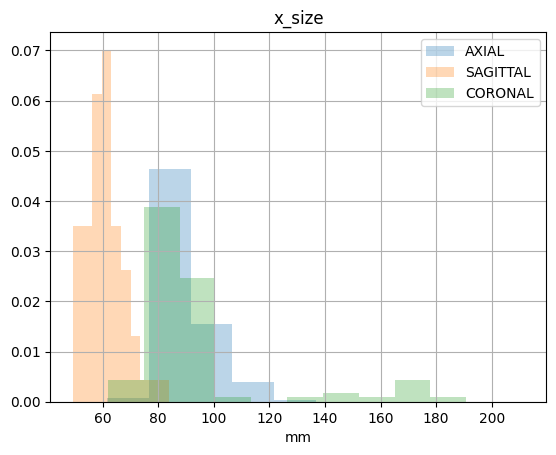

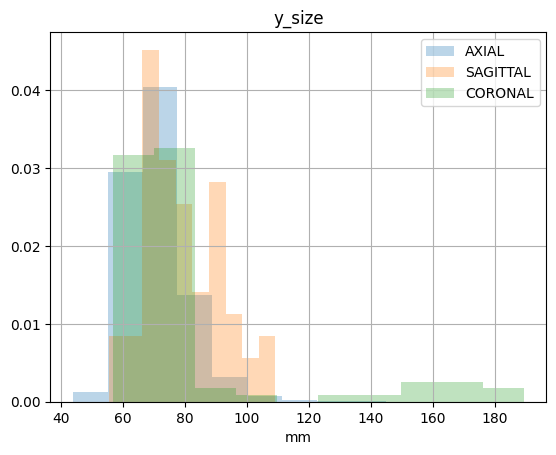

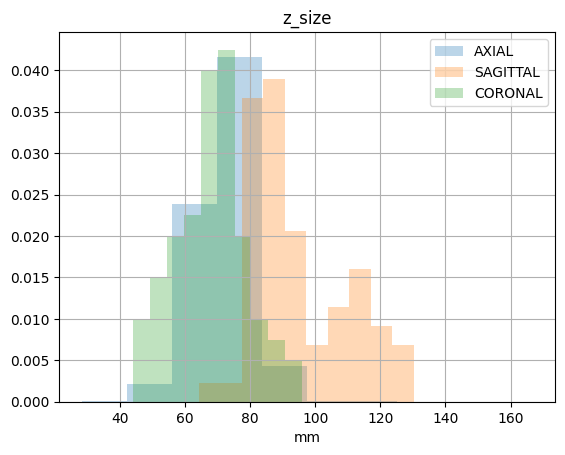

In [10]:
plt.figure()
for plane in ['AXIAL', 'SAGITTAL', 'CORONAL']:
    df_plane = df[df['OrientationLabel']==plane]
    df_plane['x_size'].hist(label=plane, alpha=0.3, density=True)
plt.title('x_size')
plt.xlabel('mm')
plt.legend()

plt.figure()
for plane in ['AXIAL', 'SAGITTAL', 'CORONAL']:
    df_plane = df[df['OrientationLabel']==plane]
    df_plane['y_size'].hist(label=plane, alpha=0.3, density=True)
plt.title('y_size')
plt.xlabel('mm')
plt.legend()

plt.figure()
for plane in ['AXIAL', 'SAGITTAL', 'CORONAL']:
    df_plane = df[df['OrientationLabel']==plane]
    df_plane['z_size'].hist(label=plane, alpha=0.3, density=True)
plt.title('z_size')
plt.xlabel('mm')
plt.legend()

In [11]:
df.to_csv('train_add_metadata_v5_roi.csv', index=False)

In [12]:
# idx = 1
# df_plane = df_seg[df_seg['OrientationLabel']=='CORONAL']
# sid = df_plane['SeriesInstanceUID'].iloc[idx]
# row = df_seg[df_seg['SeriesInstanceUID']==sid].iloc[0]
# img_files = row['sorted_files']
# sid = row['SeriesInstanceUID']
# modality = row['Modality']
# plane = row['OrientationLabel']
# if not isinstance(img_files, list):
#     img_file = list(Path(f'/kaggle/input/rsna-intracranial-aneurysm-detection/series/{sid}').glob('*'))[0]
#     imgs = load_dicom_array_3d(img_file)
# else:
#     imgs = load_dicom_array_2d(img_files)
#     y_spacing, x_spacing = row['PixelSpacing']
#     z_spacing = row['z_spacing']
#     # imgs = resample_zyx(imgs,
#     #                     spacing=(z_spacing, y_spacing, x_spacing),
#     #                     new_spacing=(1., 1., 1.),
#     #                     order=1
#     #                    )
# if modality=='CTA':
#     imgs = value_normalize(imgs, -100, 600)
# else:
#     imgs = pct_normalize(imgs, 1, 99)
# try:
#     x1, x2, y1, y2, z1, z2 = int(row['x1']), int(row['x2']), int(row['y1']), int(row['y2']), int(row['z1']), int(row['z2'])
# except:
#     x1, x2, y1, y2, z1, z2 = 0, 0, 0, 0, 0, 0
# Z, H, W = imgs.shape
# z_mid, h_mid, w_mid = Z//2, H//2, W//2
# img = imgs[z_mid]
# cv2.rectangle(img, (x1, y1), (x2, y2), 255, 2)
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# img = imgs[:,h_mid,:]
# cv2.rectangle(img, (x1, z1), (x2, z2), 255, 2)
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# img = np.ascontiguousarray(imgs[:,:,w_mid])
# cv2.rectangle(img, (y1, z1), (y2, z2), 255, 2)
# plt.figure(figsize=(5,5))
# plt.imshow(img)

# files = Path('/kaggle/input/rsna2025-series-yolo-prediction/ens_out/overlays').glob(f'*/*/*/images/{sid}*')
# for file in files:
#     img = cv2.imread(file)
#     plt.figure(figsize=(5,5))
#     plt.imshow(img)

In [13]:
# df_miss = df_seg.loc[df_seg['x1'].isna()&df_seg['y1'].isna()&df_seg['z1'].isna()].reset_index(drop=True)
# df_miss